## Introduction 
### Group: 
8

### Members: 
Sandro Sage, Gowsigaa Sathiyaseelan, Sirine Gloulou, Michalina Janik, Otso Lauerma

We are confirming that everyone worked on this project and everyone trained various models.

### Structure of the notebook:
1.At the beginning the data is devided into the needed structure for the ImageDataGenerator()

![Directory](IMG/directory_tree.png)

2.Then different models are built within the functional API of keras(outlook: maybe also use multi-branch model architecture)

3.Plot the training/validation loss and accuracy for each model.

4.Choose the model with the highest accuracy and the best results

5.Visualize different kernel filters of the first Convolutional layer

5.Visualize feature map after first convolution by giving an example image of the ImageGenerator-dataset




In [31]:
import os
import shutil
import glob

# generation of a tree directory and division of data into training, testing and validation with a ratio of 80%, 10% and 10%. 
# This way the biggest part is dedicated to training and the model is able to have the highest accuracy, this was confirmed on these following websites 
# (https://www.sciencedirect.com/science/article/pii/S2589004222003017, https://link.springer.com/article/10.1007/s42979-021-00695-5, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8423280/)

def train_test_val_split(size, train_split, test_split, src_dir):   # passing arguments for dataset size, ratio of each split set, source directory
    category = ["normal", "pneumonia"]                              # list of categories for classification: normal and pneunomia
    split_list = ["train", "test", "val"]                           # list of subdirectories regarding split of dataset
    for split in split_list:                                        # loop over the split list
        if not os.path.exists("Project_Day\\" + split + "\\" ):     # checking wether a directory exists, if not create one
            os.mkdir("Project_Day\\" + split + "\\")                
        for cat in category:                                        # now: create another subdirectory for classification 
            if not os.path.exists("Project_Day\\" + split + "\\" + cat + "\\"): 
                os.mkdir("Project_Day\\" + split + "\\" + cat + "\\")
   
    index = 1                                                          
    
    # splitting the data from the main data directory based on the file name and distribute them according 
    # to the ratio mentioned above
    # shutil.copy() copies the images into another directory

    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        if (index<=(size*train_split)):
            if "normal" in jpgfile:                                 # checking if string is in file name
                shutil.copy(jpgfile, "Project_Day\\" + "train\\" + "normal\\")

            else:                                                   # if not: copy it into the other classification directory
                shutil.copy(jpgfile, "Project_Day\\" + "train\\" + "pneumonia\\")

            index+=1                                                # just an auxiliary variable for using ratio

        # multiply ratio with dataset size to get the number of how many images have to be copy into the right split directory

        elif ((size*train_split)<index<=((size*train_split)+ (size*test_split))):
            if "normal" in jpgfile:                                 # checking if string is in file name
                shutil.copy(jpgfile, "Project_Day\\" + "test\\" + "normal\\")

            else:                                                   # if not: copy it into the other classification directory
                shutil.copy(jpgfile, "Project_Day\\" + "test\\" + "pneumonia\\")

            index+=1                                                # just an auxiliary variable for using ratio
        
        else:
            if "normal" in jpgfile:                                 # checking if string is in file name
                shutil.copy(jpgfile, "Project_Day\\" + "val\\" + "normal\\")

            else:                                                   # if not: copy it into the other classification directory
                shutil.copy(jpgfile, "Project_Day\\" + "val\\" + "pneumonia\\")


In [32]:
train_test_val_split(2200, 0.8, 0.1, "Project_Day\\data")           #call of function to split data

In [35]:
# this jupyter cell is only for checking if the data was splitted correctly according to the dataset size and the ratio

index = 0
for file in os.listdir("Project_Day\\val\\pneumonia"):              
    index+=1
print(index)

110


In [33]:
from keras.preprocessing.image import ImageDataGenerator

# the color values are being normalized from (1,255) to (0,1).

# the images are augmented in small amounts to achieve robustness towards small inconsistencies in the input images 
# using most of the data augmentation parameters, but flipping is being overlooked due to asymmetries in the human body
# assuming the input data comes from a decently controlled environment, decision to keep all values low

train_datagen = ImageDataGenerator(
        rescale=1./255,                                                 # scaling down the pixel value of the images
        shear_range=0.05,
        zoom_range=0.05,
        horizontal_flip=False,                                          # no use: inability of classify images anymore
        rotation_range=3, 
        brightness_range=[0.9,1.1])

val_datagen = ImageDataGenerator(rescale=1./255)                        # create a separate ImageDataGenerator 
                                                                        # for only scaling the images


# This helps with memory management during training and validation.
# Target_size corresponds to our input image dimensions. 
# The ProjectData folder holds subfolders for training, validation and testing, all of which have subfolders for both classes 'normal' and 'pneumonia'.
# flow_from_directory() is used if the data is distributed in directories (also possible, but not needed: flow_from_dataframe())
# and fetches data from a directory in small batches at a time

train_generator = train_datagen.flow_from_directory(
        'Project_Day/train',                                            # path to training data 
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')
        
validation_generator = val_datagen.flow_from_directory(
        'Project_Day/val',                                              #path to validation data
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

Found 1760 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [31]:
validation_generator.class_indices                                      #get the indices of classes
                                                                        

{'normal': 0, 'pneumonia': 1}

### First Model
    Dropout(0.3)
    MaxPooling()
    Conv2D with (3x3) and (5x5)
    Flatten()
    3 Dense() with (64,32,1)

In [10]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import Input
from keras.utils.vis_utils import plot_model
import visualkeras 

# create the architecture of the structure using the functional API of keras 
# Convolutional layers are being used to look for interesting features. 
#     These are translation invariant by default which should help with the different shaped bodies of the patients.
#     The number of filters in the convolutional layers indicate the number of different features that the layers will be looking for.
#     The kernel size is one of common practice. These kernels are pretty small which corresponds to looking for low-level features. 
#     By stacking multiple convolutional layers we can achieve higher and higher level features.
# Dropout is introduced to have stronger individual nodes. 
# MaxPooling helps tame parameter numbers.
# Layer flattening has to be used to reduce dimensionality to connect convolutional layers to dense ones.

# The output layer activation function is sigmoid since this is a binary classification problem.
#     Sigmoid provides us with values between [0,1]. This gives us a confidence value for our prediction.
#     We could also use the SoftMax activation function, but it is more suited for multi-categorical classification problems.
# For a loss function we use BinaryCrossentropy for the same reason as above mentioned. incase of the Binary classification we use one output neuron.
# Regarding optimizers, we've stuck to the basics of gradient descent and used Adam and Nadam (in different runs). 
#     They have differences namely in how they function around local minima, but for the most part they are identical.

input_layer = Input(shape=(256,256,3), name='input_layer')
conv_1 = Conv2D(64, kernel_size=(5,5), activation="relu")(input_layer)
conv_2 = Conv2D(32,kernel_size=(3,3), activation="relu")(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), strides=(1,1))(conv_2)
conv_3 = Conv2D(32, kernel_size=(3,3), activation="relu")(pool_1)
flatten = Flatten()(conv_3)
dropout = Dropout(0.3)(flatten)
dense_1 = Dense(64, activation="relu")(dropout)
dense_2 = Dense(32, activation="relu")(dense_1)
output_layer = Dense(1, activation="sigmoid")(dense_2)                      # act_func: sigmoid for binary classification
model = Model(input_layer, output_layer)                                    # finally build model

dot_img_file = 'model_2.png'
#plot_model(model, to_file=dot_img_file, show_shapes=True)                  # only used for plotting the architecture of model
model.summary()                                                             # give a summary of layers
#visualkeras.layered_view(model)                                            # creates another plot for CNN models

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 64)      4864      
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 250, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 flatten_2 (Flatten)         (None, 1952288)           0         
                                                           

In [11]:
from keras.losses import BinaryCrossentropy
batch_size = 32
epochs = 15
steps_per_epochs=128

# compile the model with optimizer seet to adam and loss_func to BinaryClassification()
# get the accuary of the model 

model.compile(loss=BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])

In [12]:
# train/fit the model with given train and validation dataset
# epochs: 15
# batch size: 128

history = model.fit(train_generator, batch_size=128, epochs=epochs, validation_data=validation_generator)

Epoch 1/15
55/55 [==============================] - 362s 6s/step - loss: 0.9210 - accuracy: 0.6778 - val_loss: 0.2786 - val_accuracy: 0.8909
Epoch 2/15
55/55 [==============================] - 354s 6s/step - loss: 0.3582 - accuracy: 0.8591 - val_loss: 0.2419 - val_accuracy: 0.9045
Epoch 3/15
55/55 [==============================] - 353s 6s/step - loss: 0.2544 - accuracy: 0.8972 - val_loss: 0.2293 - val_accuracy: 0.8955
Epoch 4/15
55/55 [==============================] - 355s 6s/step - loss: 0.2916 - accuracy: 0.8926 - val_loss: 0.4353 - val_accuracy: 0.8136
Epoch 5/15
55/55 [==============================] - 352s 6s/step - loss: 0.2407 - accuracy: 0.9091 - val_loss: 0.2402 - val_accuracy: 0.9045
Epoch 6/15
55/55 [==============================] - 748s 14s/step - loss: 0.2268 - accuracy: 0.9114 - val_loss: 0.2513 - val_accuracy: 0.9000
Epoch 7/15
55/55 [==============================] - 422s 8s/step - loss: 0.1979 - accuracy: 0.9222 - val_loss: 0.2360 - val_accuracy: 0.8818
Epoch 8/15
5

In [13]:
# save first trained model

model.save("sandro_V1.h5")

In [16]:
import numpy as np

# get the insights out of the history variable
# use specific keys for getting the different data points regarding the epoch steps

print(history.history.keys())
loss = history.history["loss"]
accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

# unfortunately bullshit, but we have used it
max_acc = accuracy[np.argmax(accuracy)]
max_val_acc = val_accuracy[np.argmax(val_accuracy)]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


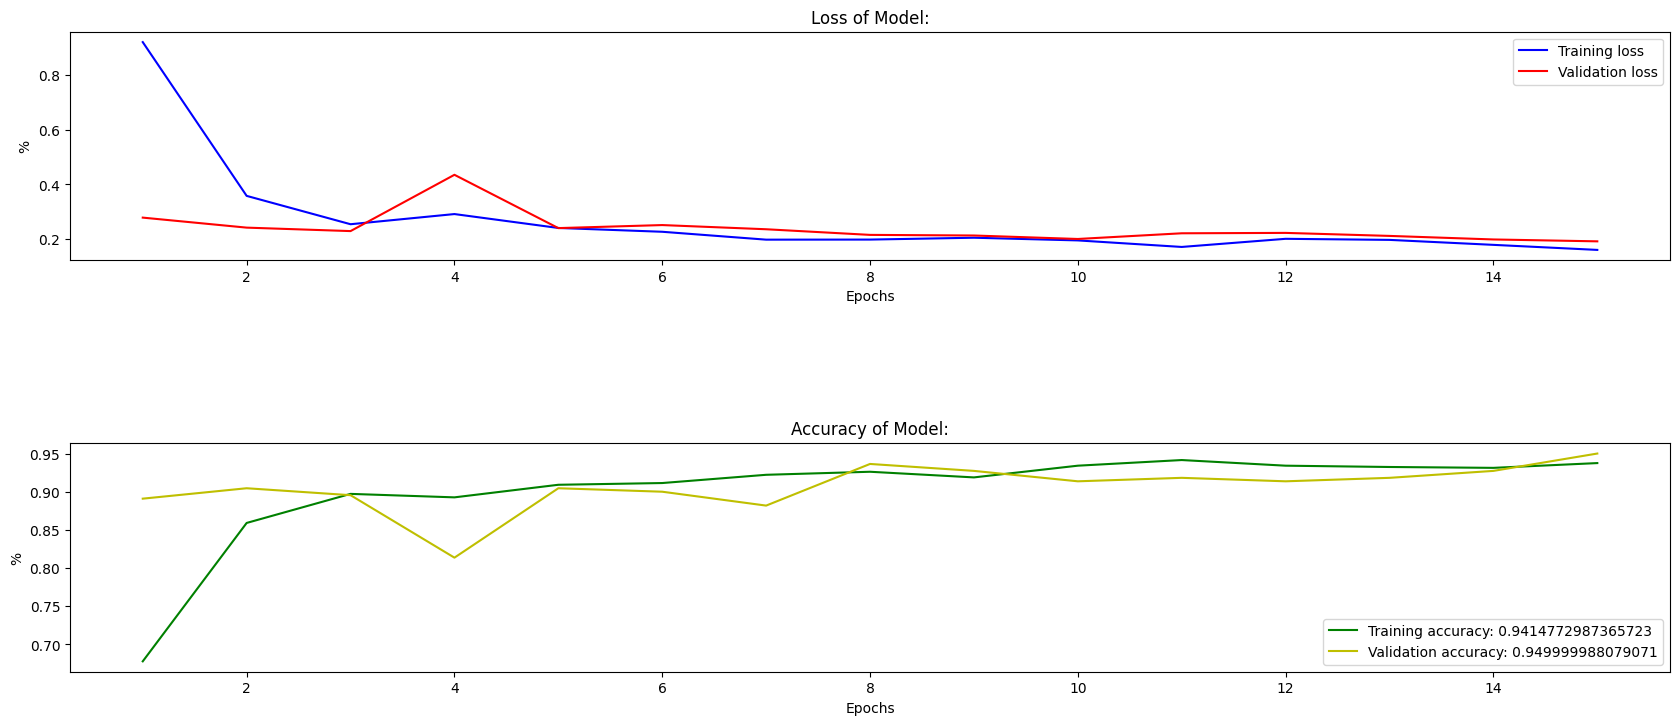

In [18]:
import matplotlib.pyplot as plt
                                                                        
# visualization method for the results
epochs_size = 15
epochs = range(1, (epochs_size+1))
ig, ax = plt.subplots(2, figsize=(20, 8))                               # creating two subplots: each one for loss/acc                           
ax[0].plot(epochs ,loss, "b", label="Training loss")
ax[0].plot(epochs, val_loss, "r", label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("%")
ax[0].set_title("Loss of Model:")
ax[0].legend()
ax[1].plot(epochs, accuracy, "g", label="Training accuracy: " + str(max_acc))
ax[1].plot(epochs, val_accuracy, "y", label="Validation accuracy: " + str(max_val_acc))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("%")
ax[1].set_title("Accuracy of Model:")
ax[1].legend()

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

plt.show()

### Second Model
    Dropout(0.3)
    more MaxPooling()
    more Conv2D with (3x3)
    Flatten()
    4 Dense() with (64,64,32,1)

In [22]:
input_layer = Input(shape=(256,256,3), name='input_layer')
conv_1 = Conv2D(64, kernel_size=(3,3), activation="relu")(input_layer)
conv_2 = Conv2D(64,kernel_size=(3,3), activation="relu")(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation="relu")(pool_1)
conv_4 = Conv2D(128, kernel_size=(3,3), activation="relu")(conv_3)
pool_2 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv_4)
flatten = Flatten()(pool_2)
dropout = Dropout(0.3)(flatten)
dense_1 = Dense(64, activation="relu")(dropout)
dense_2 = Dense(64, activation="relu")(dense_1)
dense_3 = Dense(32, activation="relu")(dense_2)
output_layer = Dense(1, activation="sigmoid")(dense_3)
model_v2 = Model(input_layer, output_layer)
model_v2.compile(loss=BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])
epochs = 10
import tensorflow as tf

# use of ModelCheckpoint to store only the best model according the best results

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='sandro_V2.h5',
    monitor='val_loss',
    save_best_only=True)

history = model_v2.fit(train_generator, batch_size=128, epochs=epochs, validation_data=validation_generator, callbacks=callback)

Epoch 1/10
55/55 [==============================] - 442s 8s/step - loss: 0.7611 - accuracy: 0.5960 - val_loss: 0.3298 - val_accuracy: 0.8727
Epoch 2/10
55/55 [==============================] - 442s 8s/step - loss: 0.3656 - accuracy: 0.8415 - val_loss: 0.3241 - val_accuracy: 0.8591
Epoch 3/10
55/55 [==============================] - 445s 8s/step - loss: 0.4706 - accuracy: 0.8568 - val_loss: 0.1810 - val_accuracy: 0.9455
Epoch 4/10
55/55 [==============================] - 442s 8s/step - loss: 0.2543 - accuracy: 0.9034 - val_loss: 0.1932 - val_accuracy: 0.9182
Epoch 5/10
55/55 [==============================] - 434s 8s/step - loss: 0.2304 - accuracy: 0.9119 - val_loss: 0.2256 - val_accuracy: 0.9273
Epoch 6/10
55/55 [==============================] - 450s 8s/step - loss: 0.4198 - accuracy: 0.8636 - val_loss: 0.2810 - val_accuracy: 0.9000
Epoch 7/10
55/55 [==============================] - 439s 8s/step - loss: 0.2484 - accuracy: 0.9045 - val_loss: 0.2402 - val_accuracy: 0.9227
Epoch 8/10
55

In [23]:
import numpy as np
print(history.history.keys())
loss = history.history["loss"]
accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]
max_acc = accuracy[np.argmax(accuracy)]
max_val_acc = val_accuracy[np.argmax(val_accuracy)]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


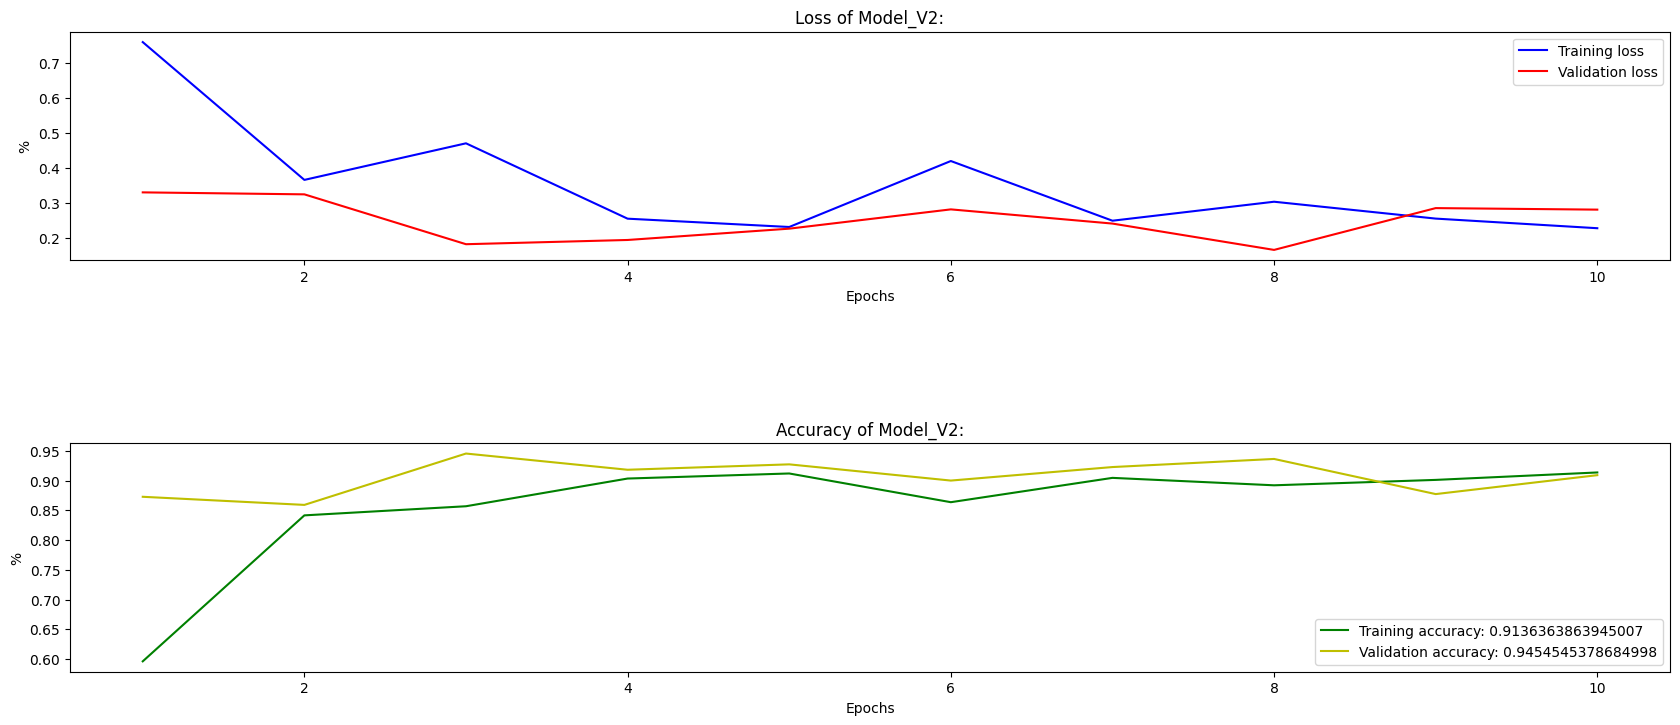

In [26]:
import matplotlib.pyplot as plt
epochs_size = 10
epochs = range(1, (epochs_size+1))
ig, ax = plt.subplots(2, figsize=(20, 8))
ax[0].plot(epochs ,loss, "b", label="Training loss")
ax[0].plot(epochs, val_loss, "r", label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("%")
ax[0].set_title("Loss of Model_V2:")
ax[0].legend()
ax[1].plot(epochs, accuracy, "g", label="Training accuracy: " + str(max_acc))
ax[1].plot(epochs, val_accuracy, "y", label="Validation accuracy: " + str(max_val_acc))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("%")
ax[1].set_title("Accuracy of Model_V2:")
ax[1].legend()

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

plt.show()

### Third Model
    Dropout(0.3)
    MaxPooling()
    Conv2D with (3x3) and (5x5)
    Flatten()
    4 Dense() with (64,64,32,1)
    L2(0.02) as kernel regularizer on Dense layer

In [34]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import L2
from keras.models import Model
from keras import Input
from keras.utils.vis_utils import plot_model
import visualkeras 

input_layer = Input(shape=(256,256,3), name='input_layer')
conv_1 = Conv2D(64, kernel_size=(5,5), activation="relu")(input_layer)
conv_2 = Conv2D(32,kernel_size=(3,3), activation="relu")(conv_1)
pool_1 = MaxPooling2D(pool_size=(2,2), strides=(1,1))(conv_2)
conv_3 = Conv2D(32, kernel_size=(3,3), activation="relu")(pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2), strides=(1,1))(conv_3)
flatten = Flatten()(pool_2)
dropout = Dropout(0.3)(flatten)
dense_1 = Dense(64, activation="relu")(dropout)
dense_2 = Dense(64, activation="relu", kernel_regularizer=L2(0.02))(dense_1)
dense_3 = Dense(32, activation="relu")(dense_2)
output_layer = Dense(1, activation="sigmoid")(dense_3)
model_v3 = Model(input_layer, output_layer)

dot_img_file = 'model_2.png'
#plot_model(model, to_file=dot_img_file, show_shapes=True)
model.summary()
#visualkeras.layered_view(model) 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 124, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 128)     147584    
                                                           

In [35]:
model_v3.compile(loss=BinaryCrossentropy(), optimizer="adam", metrics=["accuracy"])
epochs = 20
import tensorflow as tf

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='sandro_V3.h5',
    monitor='val_loss',
    save_best_only=True)

history_3 = model_v3.fit(train_generator, batch_size=128, epochs=epochs, validation_data=validation_generator, callbacks=callback)

Epoch 1/20
55/55 [==============================] - 405s 7s/step - loss: 1.8466 - accuracy: 0.6222 - val_loss: 1.3800 - val_accuracy: 0.7273
Epoch 2/20
55/55 [==============================] - 394s 7s/step - loss: 1.0894 - accuracy: 0.8239 - val_loss: 1.0245 - val_accuracy: 0.8000
Epoch 3/20
55/55 [==============================] - 391s 7s/step - loss: 0.6776 - accuracy: 0.9278 - val_loss: 0.7078 - val_accuracy: 0.8909
Epoch 4/20
55/55 [==============================] - 390s 7s/step - loss: 0.7019 - accuracy: 0.9187 - val_loss: 0.5074 - val_accuracy: 0.9455
Epoch 5/20
55/55 [==============================] - 385s 7s/step - loss: 0.6388 - accuracy: 0.9091 - val_loss: 0.6496 - val_accuracy: 0.8818
Epoch 6/20
55/55 [==============================] - 408s 7s/step - loss: 0.4507 - accuracy: 0.9653 - val_loss: 0.5215 - val_accuracy: 0.9409
Epoch 7/20
55/55 [==============================] - 382s 7s/step - loss: 0.4429 - accuracy: 0.9500 - val_loss: 0.5778 - val_accuracy: 0.9136
Epoch 8/20
55

In [37]:
import numpy as np
print(history_3.history.keys())
loss = history_3.history["loss"]
accuracy = history_3.history["accuracy"]
val_loss = history_3.history["val_loss"]
val_accuracy = history_3.history["val_accuracy"]
max_acc = accuracy[np.argmax(accuracy)]
max_val_acc = val_accuracy[np.argmax(val_accuracy)]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


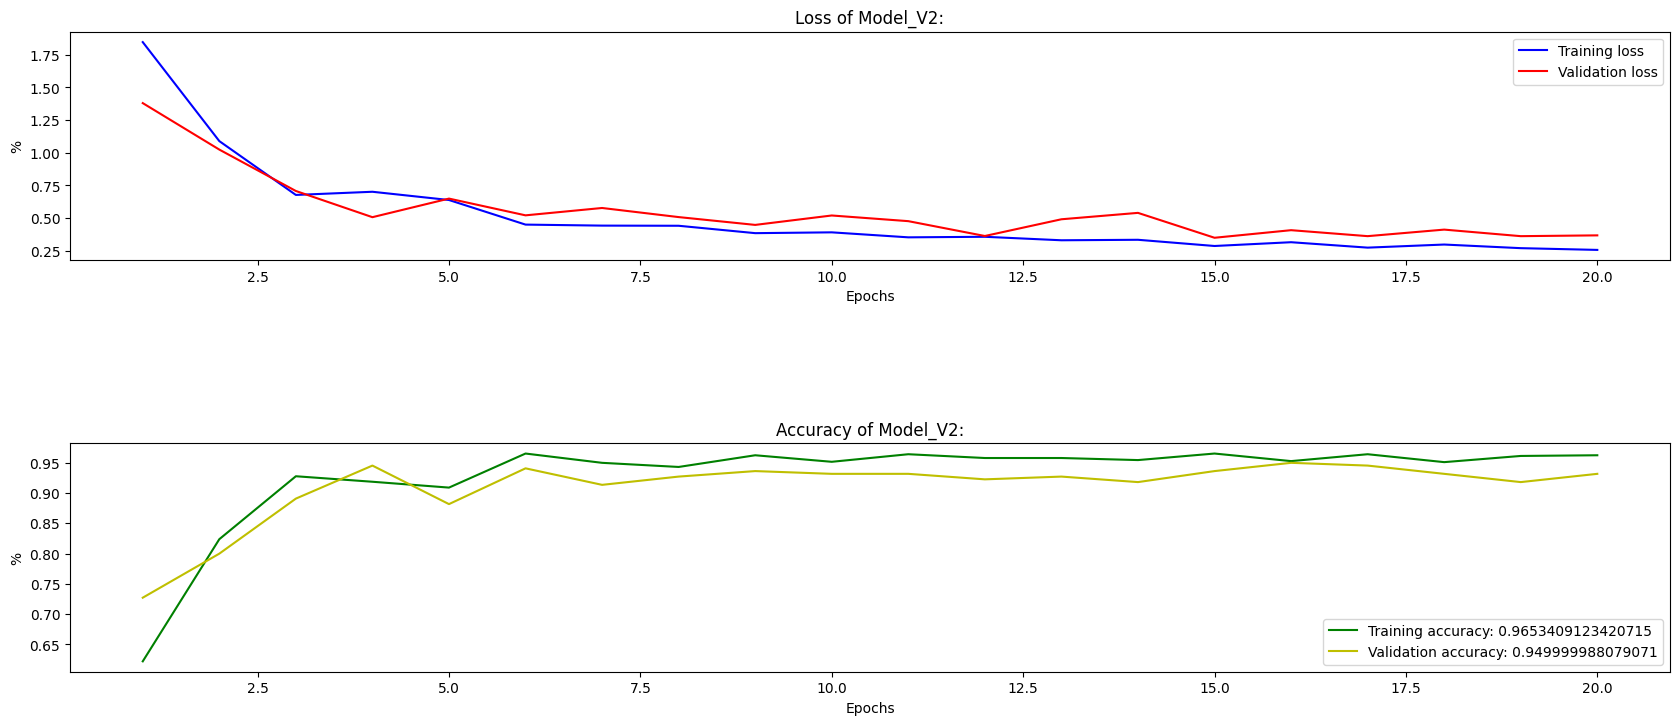

In [38]:
import matplotlib.pyplot as plt
epochs_size = 20
epochs = range(1, (epochs_size+1))
ig, ax = plt.subplots(2, figsize=(20, 8))
ax[0].plot(epochs ,loss, "b", label="Training loss")
ax[0].plot(epochs, val_loss, "r", label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("%")
ax[0].set_title("Loss of Model_V2:")                                        # mistake: forgot to change model name 
ax[0].legend()
ax[1].plot(epochs, accuracy, "g", label="Training accuracy: " + str(max_acc))
ax[1].plot(epochs, val_accuracy, "y", label="Validation accuracy: " + str(max_val_acc))
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("%")
ax[1].set_title("Accuracy of Model_V2:")                                    # mistake: forgot to change model name                    
ax[1].legend()

# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

plt.show()

### Result
    the third model has the best results according validation/training loss and accuracy

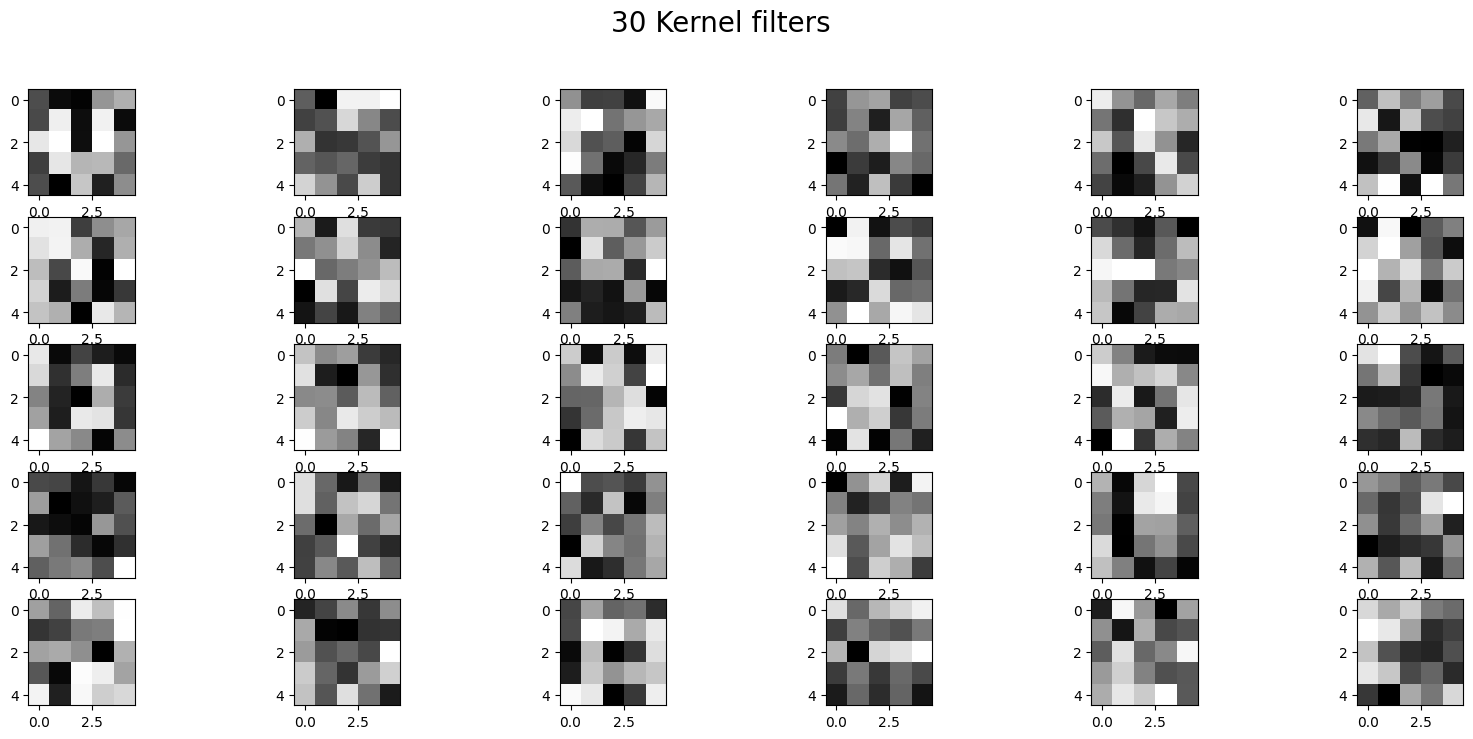

In [40]:
import matplotlib.pyplot as plt

# get the kernel filters and then visualize them with matplotlib
# ability to choose how many rows and columns (how many filters) you want to show

def get_kernels(layer_name, rows, columns):
    # get weights of first layer (here: Conv2D with 5x5 kernel size)
    kernels = model_v3.get_layer(name=layer_name).get_weights()[0][:,:,0, :]    
    index = 0
    fig, ax = plt.subplots(rows,columns, figsize=(20, 8))
    for row in range(0,rows):
        for col in range(0,columns):
            ax[row][col].imshow(kernels[:,:,index], cmap="gray")
            index += 1
    plt.suptitle(str(rows*columns) + ' Kernel filters',fontsize=20)
    plt.show()

get_kernels("conv2d_17", 5, 6)

### Stuff for more insights on the ImageDataGenerator
    code strategy for getting one image of Generator -> Iterator object
    
    Steps:
        1. show one image
        2. return the image

In [76]:
#Import the required libaries
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math

In [77]:
import matplotlib.pyplot as plt
x,y = next(validation_generator)
# generate samples and plot
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# # generate batch of images
# for i in range(3):

#     # convert to unsigned integers
#     image = next(validation_generator)[].astype('uint8')
#     print(image.shape)
#     # plot image
#     #ax[i].imshow(image)
#     #ax[i].axis('off')'
print(x.shape)
print(y.shape)

(32, 256, 256, 3)
(32,)


(256, 256, 3)

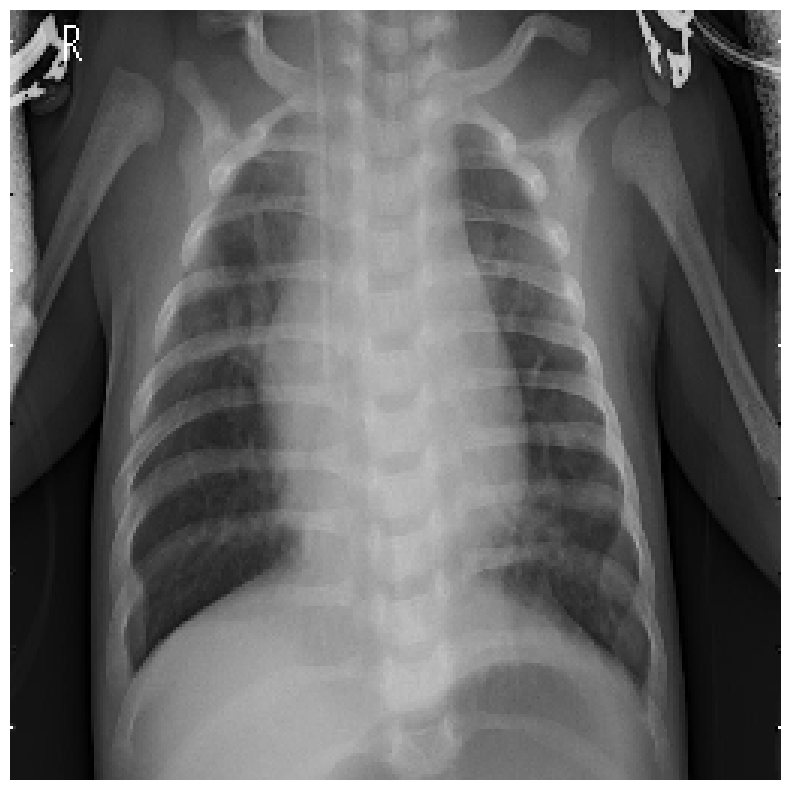

In [89]:
def show_grid(image_list,nrows,ncols,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    
    ax = grid[0]
    ax.imshow(image_list[0],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
    ax.axis('off')

    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

    return image_list[0]


image_fm = show_grid(x,1,1,show_labels=True,figsize=(20,10))
image_fm.shape

1/1 [==============================] - 0s 84ms/step


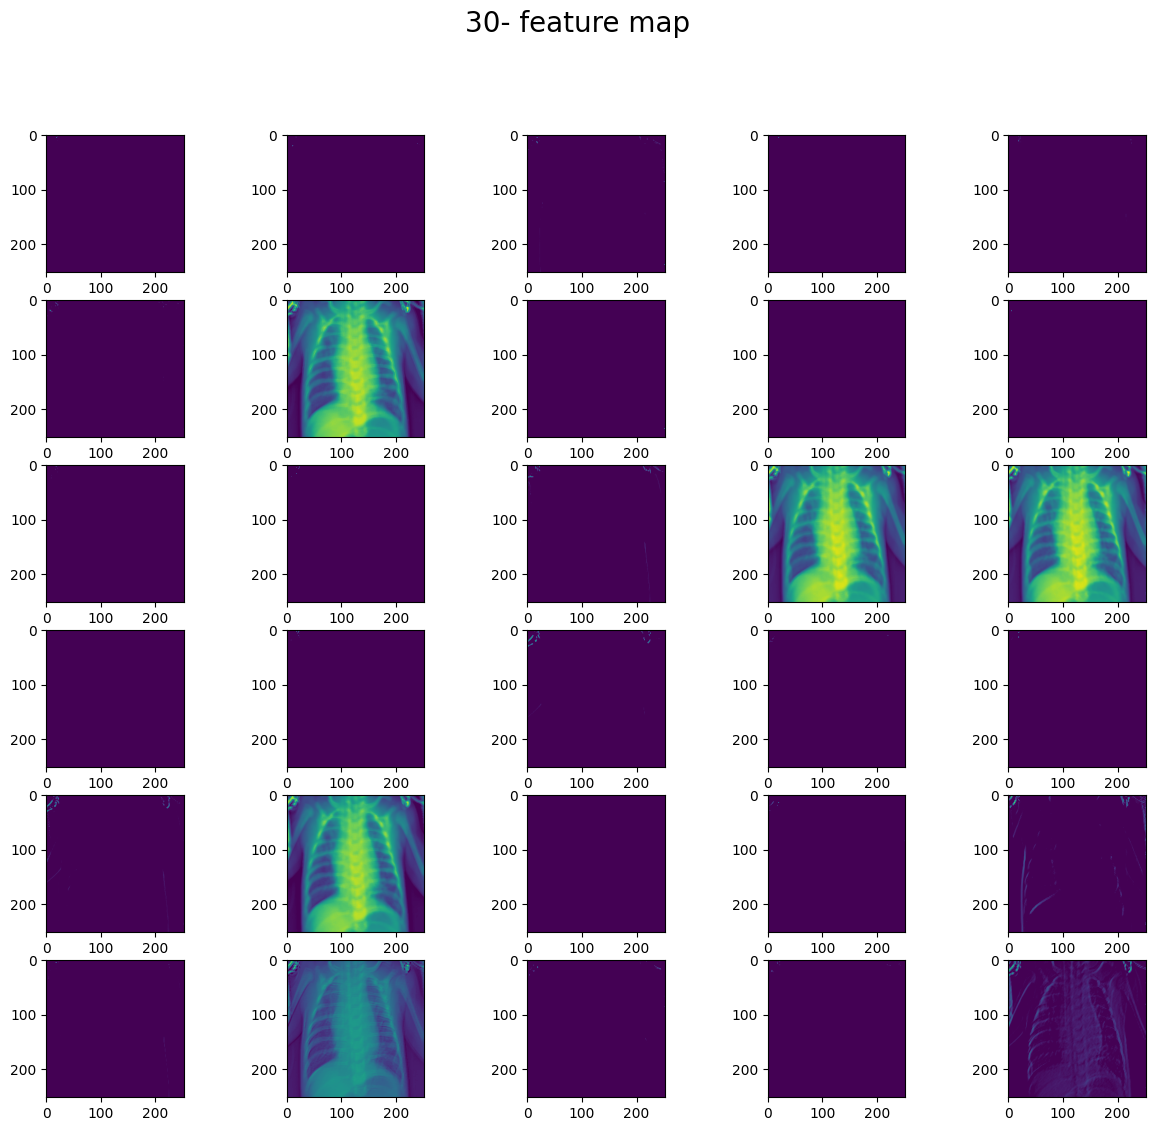

In [94]:
from keras.models import Model
def plot_feature_map(rows, columns):
    # get the activation model of the chosen layer 
    activation_model = Model(inputs=model_v3.input, outputs=model_v3.layers[1].output)

    # let the image from the ImageDataGenerator pass through the layer, to see the feature map
    activations = activation_model.predict(image_fm.reshape(1,256,256,3))   # reshape needed into specific dimension
    act_index = 0
    fig, ax = plt.subplots(rows,columns, figsize=(rows*2.5, columns*2.5))
    for row in range(0,rows):
        for col in range(0,columns):
            ax[row][col].imshow(activations[0, :, :, act_index])
            act_index+= 1
    plt.suptitle(str(rows*columns) + '- feature map',fontsize=20)
    plt.show()   

plot_feature_map(6,5)                                                       # call of function

In [2]:
# testing if loading of models works

from keras.saving.save import load_model

test_model = load_model("sandro_V1.h5")
test1_model = load_model("sandro_V2.h5")
test2_model = load_model("sandro_V3.h5")

In [19]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)   
testing_generator = test_datagen.flow_from_directory(
        'Project_Day/test',                                              #path to validation data
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

x_test, y_test = next(testing_generator)
#test2_model.predict(x_test)
score = test2_model.evaluate(x_test, y_test)
history = test2_model.history
print('Accuracy on test data: {}% \nLoss in test data: {}'.format(score[1], score[0]))


Found 220 images belonging to 2 classes.
1/1 [==============================] - 1s 1s/step - loss: 0.2427 - accuracy: 0.9688
Accuracy on test data: 0.96875% 
Loss in test data: 0.2426626980304718
